In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from datetime import date, datetime
import time
import calendar
path = 'data/'

In [18]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
sub = pd.read_csv(path + 'sample_submission.csv')

oil = pd.read_csv(path + 'oil.csv')
holiday = pd.read_csv(path + 'holidays_events.csv')
store = pd.read_csv(path + 'stores.csv')
tran = pd.read_csv(path + 'transactions.csv')

In [3]:
def preprocess_train(df):
    df['date'] = df['date'].map(lambda x: date.fromisoformat(x))
    df['weekday'] = df['date'].map(lambda x: x.weekday())
    df['year'] = df['date'].map(lambda x: x.year)
    df['month'] = df['date'].map(lambda x: x.month)
    df['day'] = df['date'].map(lambda x: x.day)
    df['eomd'] = df['date'].map(lambda x: calendar.monthrange(x.year, x.month)[1])
    df['payday'] = ((df['day'] == df['eomd'])|(df['day'] == 15)).astype(int)
    df = df.drop(['id', 'eomd'], axis=1)
    return df

train = preprocess_train(train)
test = preprocess_train(test)

In [4]:
def preprocess_oil(oil):
    oil['month'] = oil['date'].map(lambda x: int(x.replace('-', '')[:6]))
    oil['month_avg'] = oil.groupby('month')['dcoilwtico'].transform('mean')
    oil['tmp'] = oil['dcoilwtico'].map(np.isnan)
    oil['month_avg'] = oil['tmp'] * oil['month_avg']
    oil['dcoilwtico'].fillna(0, inplace=True)
    oil['dcoilwtico'] = oil['dcoilwtico'] + oil['month_avg']
    oil = oil.drop(['month', 'month_avg', 'tmp'], axis=1)
    oil['date'] = oil['date'].map(lambda x: date.fromisoformat(x))
    return oil

oil = preprocess_oil(oil)

In [5]:
def preprocess_holiday(df):
    df['date'] = df['date'].map(lambda x: date.fromisoformat(x))
    df = df[(df['transferred']==False)&(df['type']!='Work Day')]
    event = df[df['type']=='Event']
    earthquake = event[event['description'].str.startswith('Terremoto Manabi')]
    event = event[event['description'].str.startswith('Terremoto Manabi')==False]
    return df, event, earthquake

holiday, event, earthquake = preprocess_holiday(holiday)

event = event[['date', 'description']]
event.rename({'description': 'event_name'}, axis=1, inplace=True)

earthquake = earthquake[['date', 'description']]
earthquake.rename({'description': 'earthquake'}, axis=1, inplace=True)

h_local = holiday[holiday['locale']=='Local']
h_local = h_local[['date', 'locale_name', 'description']]
h_local = h_local.rename({'locale_name': 'city', 'description': 'local_holiday_name'}, axis=1)

h_regional = holiday[holiday['locale']=='Regional']
h_regional = h_regional[['date', 'locale_name', 'description']]
h_regional = h_regional.rename({'locale_name': 'state', 'description': 'regional_holiday_name'}, axis=1)

h_national = holiday[holiday['locale']=='National']
h_national = h_national[['date', 'description']]
h_national = h_national.rename({'description': 'national_holiday_name'}, axis=1)

In [6]:
def merge_tables(df):
    df = df.merge(oil, on='date', how='left')
    df = df.merge(store, on='store_nbr', how='left')
    df = df.merge(event, on='date', how='left').fillna('0')
    df = df.merge(earthquake, on='date', how='left').fillna('0')
    df = df.merge(h_local, on=['date', 'city'], how='left').fillna('0')
    df = df.merge(h_regional, on=['date', 'state'], how='left').fillna('0')
    df = df.merge(h_national, on='date', how='left').fillna('0')
    df = df.merge(tran, on=['date', 'store_nbr'], how='left').fillna(0)

    return df

train = merge_tables(train)
test = merge_tables(test)

In [7]:
train['dcoilwtico'] = train['dcoilwtico'].astype(float)
test['dcoilwtico'] = test['dcoilwtico'].astype(float)

In [8]:
cat_features = ['family', 'store_nbr', 'city', 'state', 'type', 'cluster',
                'event_name', 'earthquake', 'local_holiday_name', 'regional_holiday_name', 'national_holiday_name']
for col in cat_features:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

In [9]:
def preprocess_dataset(df, train_date: list, valid_date: list):
    df['is_train'] = df['date'].map(lambda x: x in train_date)
    df['is_valid'] = df['date'].map(lambda x: x in valid_date)
    return df

train_date = train['date'].unique()[-76:-15].tolist()
valid_date = train['date'].unique()[-15:].tolist()
train = preprocess_dataset(train, train_date, valid_date)

In [10]:
y = np.log(train['sales'] + 1)
X_train = train.drop(['date', 'sales', 'year'], axis=1)
X_test = test.drop(['date', 'year'], axis=1)

In [11]:
xgb_params = {
    'tree_method': 'gpu_hist', 
    'gpu_id': 0,
    'predictor': 'gpu_predictor', 
    'verbosity': 2,
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse', 
    'random_state': 2021,
    'learning_rate': 0.009,
    'subsample': 0.99,
    'colsample_bytree': 0.80,
    'reg_alpha': 10.0,
    'reg_lambda': 0.18,
    'min_child_weight': 47,
}

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
import math

def basic_xgboost(X_train, y, xgb_params, X_test):
    start = time.time()    
    # extract train and valid dataset
    trn_idx = X_train[X_train['is_train']==True].index.tolist()
    val_idx = X_train[X_train['is_valid']==True].index.tolist()

    X_tr = X_train.loc[trn_idx, :].drop(['is_train', 'is_valid'], axis=1)
    X_val = X_train.loc[val_idx, :].drop(['is_train', 'is_valid'], axis=1)
    y_tr = y[trn_idx]
    y_val = y[val_idx]
    
    xgb_train = xgb.DMatrix(X_tr, label=y_tr)
    xgb_valid = xgb.DMatrix(X_val, label=y_val)
    evallist = [(xgb_train, 'train'), (xgb_valid, 'eval')]
    evals_result = dict()
    
    model = xgb.train(params=xgb_params, dtrain=xgb_train, evals=evallist, evals_result=evals_result,
                      verbose_eval=5000, num_boost_round=100000, early_stopping_rounds=100)
    
    
    
    xgb_oof = np.zeros(y_val.shape[0])
    xgb_oof = model.predict(xgb_valid, iteration_range=(0, model.best_iteration))
    
    xgb_test = xgb.DMatrix(X_test)
    xgb_pred = pd.Series(model.predict(xgb_test, iteration_range=(0, model.best_iteration)),
                         name='xgb_pred')
    
    elapsed = time.time() - start
    mse = mean_squared_error(y_val, xgb_oof, squared=False)
#     rmsle = np.sqrt(mean_squared_log_error(y_true=y_val, y_pred=xgb_oof))
    mae=mean_absolute_error(y_val,xgb_oof)
    print(f" rmse: {mse:.6f}\n mae: {mae:.6f} , elapsed time: {elapsed:.2f}sec\n")
    

    return xgb_oof, model, evals_result, xgb_pred

In [27]:
%%time
oof, model, evals_result, pred = basic_xgboost(X_train, y, xgb_params, X_test)

[0]	train-rmse:3.98392	eval-rmse:3.98526
[5000]	train-rmse:0.40131	eval-rmse:0.46033
[10000]	train-rmse:0.37629	eval-rmse:0.44340
[15000]	train-rmse:0.36613	eval-rmse:0.43756
[20000]	train-rmse:0.36022	eval-rmse:0.43459
[25000]	train-rmse:0.35617	eval-rmse:0.43271
[30000]	train-rmse:0.35315	eval-rmse:0.43145
[35000]	train-rmse:0.35078	eval-rmse:0.43050
[35606]	train-rmse:0.35053	eval-rmse:0.43043
 rmse: 0.430418
 mae: 0.301451 , elapsed time: 331.21sec

Wall time: 5min 32s


In [24]:
sub['sales'] = np.exp(pred) - 1
# sub.to_csv('XGB_Model.csv', index=False)

In [27]:
# feature importance
fi = pd.DataFrame()
fi['feature'] = model.get_fscore().keys()
fi['importance'] = model.get_fscore().values()
display(fi.sort_values('importance', ascending=False))

,feature,importance
1,family,376925.0
0,store_nbr,272481.0
5,day,159755.0
2,onpromotion,138771.0
11,cluster,132283.0
8,city,117877.0
7,dcoilwtico,107975.0
3,weekday,104434.0
9,state,83675.0
10,type,76754.0


<AxesSubplot:>

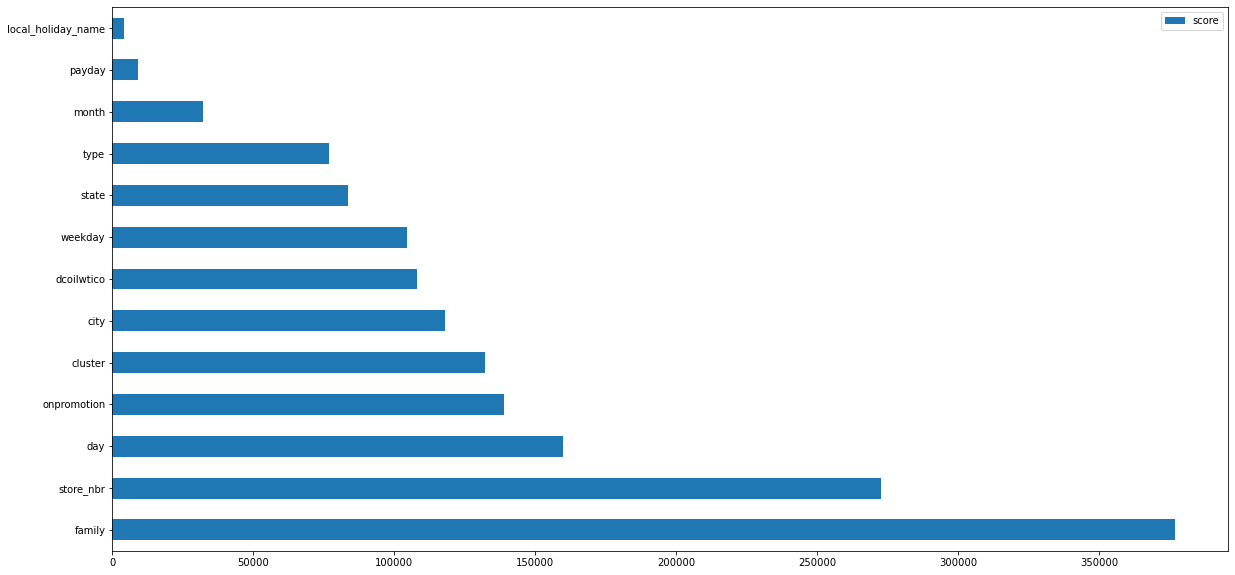

In [16]:
feature_important = model.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

#### Kagge RMSLE: 0.45